In [23]:
import os
import json
import glob
import pandas as pd

# Checkpoint 2: Exploratory Data Analysis

Our project aims to identify genes that show significantly higher/lower rates of expression amongst patients with psychiatric disorders versus a control group. We'll be conducting analysis on 352 different samples containing high throughput sequencing data taken from brain tissue RNA. This notebook walks through the cleaning process for a single sample:

# The Data

The data itself is stored in directory <code>/datasets/srp073813</code>. Each file is in a fastq.gz format, which contains the raw sequences of nucleotides that were read by the sequencing machine. Each sample has two files associated with it, one with RNA sequences that were read in one direction and another that was read in the opposite. Our sample being cleaned here is <code>SRR3438851_1.fastq.gz</code> and <code>SRR3438851_2.fastq.gz</code>. 

In [8]:
#Counts the number of corresponding pairs in the datasets file
r1 = glob.glob('/datasets/srp073813/*_1.fastq.gz')
r2 = glob.glob('/datasets/srp073813/*_2.fastq.gz')
    
paired_end_reads = []
for read in r2:
    sample = read.split("/")[3].split("_")[0]
    if sample in "".join(r1):
        paired_end_reads.append(read)
        
len(paired_end_reads)

352

# Quality Control with FastQC

FastQC is a library that is used to assess the quality of raw sequence data before any further analysis begins. It provides base statistics such as min/max read length, total reads, and %GC content (an indicator of stability).Doing quality control beforehand helps uncover biases in the data, provide context for questions you’re trying to investigate, and give you a better idea of what methods to use for analysis. Here is some information about our sample generated by FastQC:

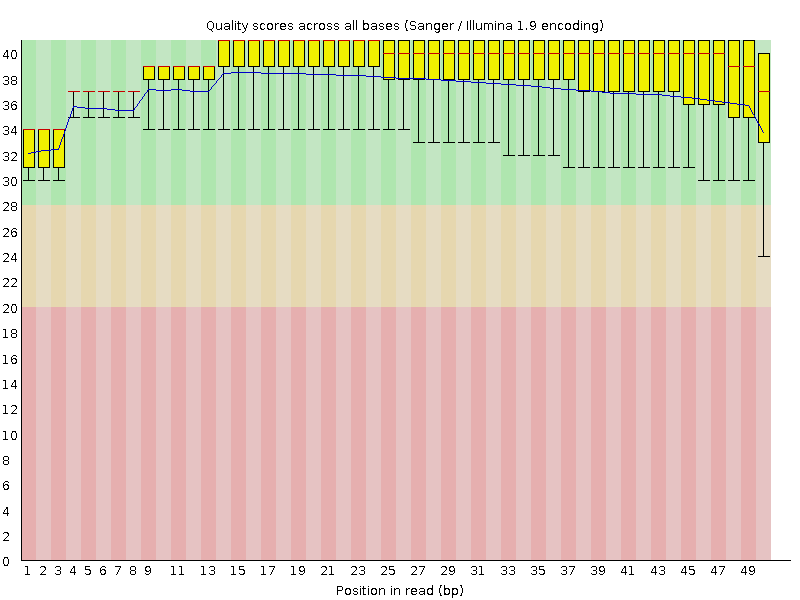

In [12]:
# This visualization displays the distribution of quality scores for each read in a sample, 
# a measure of how accurately a base was called.
from IPython.display import Image
os.chdir('..')
Image(filename='src/data/fastqc_results/unzipped/SRR3438851_1_fastqc/Images/per_base_quality.png') 

In [13]:
# summary.txt contains baseline stats about the sample so that quality checks can be easily automated.
f = open("src/data/fastqc_results/unzipped/SRR3438851_1_fastqc/summary.txt", "r")
print(f.read())

PASS	Basic Statistics	SRR3438851_1.fastq.gz
PASS	Per base sequence quality	SRR3438851_1.fastq.gz
PASS	Per sequence quality scores	SRR3438851_1.fastq.gz
FAIL	Per base sequence content	SRR3438851_1.fastq.gz
PASS	Per sequence GC content	SRR3438851_1.fastq.gz
PASS	Per base N content	SRR3438851_1.fastq.gz
PASS	Sequence Length Distribution	SRR3438851_1.fastq.gz
WARN	Sequence Duplication Levels	SRR3438851_1.fastq.gz
PASS	Overrepresented sequences	SRR3438851_1.fastq.gz
PASS	Adapter Content	SRR3438851_1.fastq.gz
FAIL	Kmer Content	SRR3438851_1.fastq.gz



The FastQC report shows that this run is fairly good quality. For the full experiment, we will parse through every <code>summary.txt</code> file for each sample to check for a <code>PASS</code> flag. If a sample fails the quality control check, we can either remove it entirely or clean it using techniques such as adapter trimming.

# Adapter Trimming with Cutadapt

A common error in high-throughput sequencing is the accidental inclusion of adapter sequences that aren't part of the true sequence. These adapters are used to facilitate the chemical processes needed for sequencing, but sometimes they accidentally get sequenced as part of the sample, so they need to be removed before proceeding with gene expression analysis. Cutadapt is a program that can algorithmically find and remove adapter sequences within a sample. For each contaminated sample, specify the adapter sequence you'd like to remove in the command line and run the program.

<code>> cutadapt -a AACCGGTT -o SRR3438851_1_trimmed.fastq.gz SRR3438851_1.fastq.gz</code>

# Alignment and Frequency Counts

The last step before differential expression analysis involves aligning the millions of fragments from each sample using a known reference genome, so we can then count the number of reads that were transcribed from specific genes. Both alignment and frequency counts are done using the program Kallisto. Kallisto takes in a reference genome file and the two fastq.gz files from a sample. It outputs three files: metadata about the run in <code>run_info.json</code>, the main frequency results in <code>abundance.tsv</code>, and a larger more comprehensive version of those results in <code>abundance.h5</code>.

In [22]:
#Tabular data to be used for differential expression analysis 
f = open("src/data/kallisto/SRR3438851/abundance.tsv", "r")
for i in range(5):
    print(f.readline())

target_id	length	eff_length	est_counts	tpm

NM_000014.6	4610	4369.87	8436.11	117.532

NM_000015.3	1285	1044.87	5	0.291334

NM_000016.6	2261	2020.87	621.951	18.737

NM_000017.4	1859	1618.87	694.905	26.1334



In [35]:
#Metadata about the Kallisto run
f = open("src/data/kallisto/SRR3438851/run_info.json", "r")
print(f.read())

{
	"n_targets": 78751,
	"n_bootstraps": 0,
	"n_processed": 63844616,
	"kallisto_version": "0.42.4",
	"index_version": 10,
	"start_time": "Sun Nov 15 18:32:11 2020",
	"call": "/opt/kallisto_linux-v0.42.4/kallisto quant -i /datasets/srp073813/reference/kallisto_transcripts.idx -o SRR3438851 -b 0 /datasets/srp073813/SRR3438851_1.fastq.gz /datasets/srp073813/SRR3438851_2.fastq.gz"
}



# That's it!

These are the main steps of the cleaning process. Once every sample has gone through quality control, adapter trimming if needed, alignment, and gene counts, gene expression analysis using R's DESeq2 package can begin.